In [1]:
#!/home/emfreese/anaconda3/envs/gchp/bin/python
#SBATCH --time=24:00:00

#SBATCH --cpus-per-task=4
#SBATCH --partition=edr


import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import argparse

import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

import geopandas

from numba import jit
import numpy as np
from numba import guvectorize, float64, int64, void

import scipy.signal as signal

In [2]:


####### There are three options for the type of run: weighted_co2, annual_co2, and age_retire.
####### weighted_co2 = shutdowns occur based on the percentile of capacity weighted co2 emissions (dirtier plants = bigger emissions)
####### annual_co2 = shutdowns occur based on the percentile of annual co2 emissions (so bigger plants likely = bigger co2 emissions)
####### age_retire = shutdowns occure based on the age of the plant

###### Must choose one of these four countries for emissions: 'CAMBODIA', 'INDONESIA', 'MALAYSIA', 'VIETNAM'

################## Parse arguments and set constants ##############

years = 50
coal_year_range = np.arange(0,5)
percent = np.arange(0,101)

weighted_co2 = True
age_retire = False
annual_co2 = False

country_emit = 'INDONESIA'

## Add time dimension
length_simulation = years*365
time_array = np.arange(0, length_simulation)
kg_per_g = 1e+3

## import the china global powerplant database
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

## reduce to one country for emissions

CGP_df = CGP_df.loc[CGP_df['COUNTRY'] == country_emit]

print('Emis data prepped and loaded')




Emis data prepped and loaded


In [3]:
CGP_df['BC_(g/day)'].sum()/16000000

0.024355428595004988

In [4]:
######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
country_df = geopandas.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
countries = ['China','Indonesia','Malaysia','Vietnam','Australia', 'Cambodia','Myanmar', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


######## Set health data #########

RR = 1.02 #global mean
del_x = 10 #ug/m3
beta = np.log(RR)/del_x


#2019 mortalities to match 2019 population data from the GBD 
I_val = {}
I_val['China'] = 10462043.68
I_val['Indonesia'] = 35874.09
I_val['Malaysia'] = 169483.46
I_val['Vietnam'] = 606145.89
I_val['Australia'] = 169053.20
I_val['Cambodia'] = 96284.85
I_val['Myanmar'] = 368031.84
I_val['Laos'] = 35874.09
I_val['Philippines'] = 557809.29
I_val['Nepal'] = 170032.44
I_val['Bangladesh'] = 740684.73
I_val['Thailand'] = 486556.52
I_val['Bhutan'] = 3713.40

I_val_df = pd.DataFrame(I_val.values(), index = I_val.keys()).rename(columns = {0:'Ival'}) 
I_val_df.index.rename('country', inplace = True)
pop_df = country_df.loc[country_df['country'].isin(countries)].loc[country_df['POP_YEAR'] == 2019][['country','POP_EST']].set_index('country').groupby('country').max() #select 2019 population data
I0_pop_df = pd.merge(pop_df, I_val_df, left_index=True, right_index=True) #combine Initial mortality and total population by country
I0_pop_df['I_obs'] = I0_pop_df['Ival']/I0_pop_df['POP_EST'] #calculate initial mortality rate, I_obs

regrid_area_ds = xr.open_dataset('Outputs/regridded_population_data.nc')


In [5]:

####### Functions #########

def early_retirement_by_CO2_weighted(year_early, df, CO2_val, time_array, shutdown_years):
    ''' Shutdown a plant early based on its capacity weighted CO2 emissions. Shutdowns occur by the percentile of the plant (eg: top 10%, top 90%). The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))
    #print(min_comission_yr)
    #print(shutdown_days)
    test_array = np.where(time_array <= year_early*365, True, False)
    #print('test array len', len(test_array))
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
    #fig, ax = plt.subplots()
    #plt.plot(E)
    #plt.title('E')
    #print(E)
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        #print(np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r))
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)
        #plt.plot(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)


def early_retirement_by_CO2_annual(year_early, df, CO2_val, time_array, shutdown_years):
    ''' Shutdown a plant early based on its annual CO2 emissions. Shutdowns occur by the percentile of the plant (eg: tope 10%, top 90%). The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))
    #print(min_comission_yr)
    #print(shutdown_days)
    test_array = np.where(time_array <= year_early*365, True, False)
    #print('test array len', len(test_array))
    #plt.plot(test_array)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['BC_(g/day)'].sum()
    #fig, ax = plt.subplots()
    #plt.plot(E)
    #plt.title('E')
    #print(E)
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        #print(np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r))
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)
        #plt.plot(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)
    return(E)


def early_retirement_by_year(df, time_array, shutdown_years):
    ''' Shutdown a plant early if comissioned before a certain year, all other plants stay on until they reach 40 year time limit. The df must have a variable 'Year_of_Comission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    #shutdown_years = 10
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365

    E = np.zeros(len(time_array))
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array < (year_comis-min_comission_yr)*365 + shutdown_days) & (time_array >= (year_comis-min_comission_yr)*365), True, False)
        #plt.plot(test_array)
        E += test_array* df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum()
        #plt.plot(E)
    return(E)


    
 



In [6]:

########## Create emissions profile ##########


if weighted_co2 == True:

    E_CO2_all_opts = {}
    for year in coal_year_range:
        E_CO2_all_opts[year] = {}
        for r in percent: #active
            E_CO2_all_opts[year][r] = early_retirement_by_CO2_weighted(year, CGP_df, np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'].dropna(),r), time_array, 40)
    print('Emissions profiles based on weighted capacity of CO2 emissions percentiles createdd')


elif annual_co2 == True:

    E_CO2_all_opts = {}
    for year in coal_year_range:
        E_CO2_all_opts[year] = {}
        for r in percent:
            E_CO2_all_opts[year][r] = early_retirement_by_CO2_year_annual(year, CGP_df, np.nanpercentile(CGP_df['ANNUALCO2'].dropna(),r), time_array, 40)
    print('Emissions profiles based on Annual CO2 emissions percentiles created')

    

elif age_retire == True:

    E_CO2_all_opts = {}
    for year in coal_year_range:
        E_CO2_all_opts[year] = early_retirement_by_year(CGP_df, time_array, year)
    print('Emissions profiles based on age')


Emissions profiles based on weighted capacity of CO2 emissions percentiles createdd


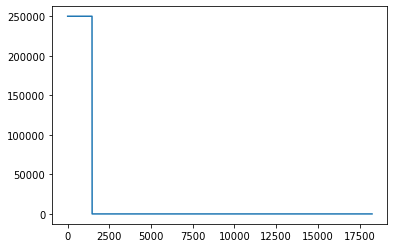

In [7]:
plt.plot(E_CO2_all_opts[4][0])

In [8]:
   
############### Convolution, selection of location, health impact assessment ##########
    

country_emit_dict = {'INDONESIA':['Indo_Jan', 'Indo_Apr', 'Indo_July','Indo_Oct'], 'CAMBODIA':['Cambod_Jan', 'Cambod_Apr', 'Cambod_July','Cambod_Oct'] , 
               'MALAYSIA': ['Malay_Jan','Malay_Apr','Malay_July','Malay_Oct'], 'VIETNAM': ['Viet_Jan','Viet_Apr','Viet_July','Viet_Oct']}

#import the green's function and set our time step
G = xr.open_dataarray('Outputs/G_all_loc_all_times_BC_total.nc4', chunks = 'auto')
dt = 1 #day
G_lev0 = G.where(G.run.isin(country_emit_dict[country_emit]), drop = True).mean(dim = 'run').isel(lev = 0).compute()
G_lev0 = G_lev0.rename({'time':'s'})
print('G prepped')



def np_to_xr(C, G, E):
    E_len = len(E)
    G_len = len(G.s)
    C = xr.DataArray(
    data = C,
    dims = ['s','lat','lon'],
    coords = dict(
        s = (['s'], np.arange(0, C.shape[0])), #np.arange(0,(E_len+G_len))),
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return(C)




G prepped


In [7]:
## define our base pollution level
E_base = early_retirement_by_year(CGP_df, time_array, 40)
ds_base = signal.convolve(G_lev0.to_numpy(), E_base[..., None, None], mode = 'full')
ds_base = np_to_xr(ds_base, G_lev0, E_base)


In [ ]:
import numpy as np
import dask.array as da
x_np = np.random.rand(1000, 1000)
x_dask = da.from_array(x_np, chunks=len(x_np) // 10)

In [22]:
import dask.array as da


In [27]:
%%time

if weighted_co2 == True:
    runtype = 'weighted'
    for yr in coal_year_range:
        for pc in percent:  
            data = pd.DataFrame(columns = ['Mortalities','BC_Conc'], index = countries)
            #concentration
            C_out =  signal.convolve(G_lev0.to_numpy(), E_CO2_all_opts[yr][pc][..., None, None], mode = 'full')
            C_out = da.from_array(C_out, chunks = [C_out.shape[0]//10,C_out.shape[1]//10,C_out.shape[2]//10])
            C_out = np_to_xr(C_out, G_lev0, E_CO2_all_opts[yr][pc])
            
            print(C_out)
            #heath impacts
            mask = country_mask.mask(C_out, lon_name = 'lon', lat_name = 'lat')
            for country_impacted in countries:
                contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
                country_impacted_ds = C_out.where(contiguous_mask)
                country_impacted_ds = country_impacted_ds.to_dataset(name = 'BC_conc')
                
                country_impacted_ds['AF'] = (np.exp(beta*(country_impacted_ds['BC_conc']- ds_base)) - 1)#/np.exp(beta*(country_impacted_ds['BC_conc']- ds_base))
                country_impacted_ds['delta_I'] = country_impacted_ds['AF']*regrid_area_ds['regrid_pop_count']*I0_pop_df.loc[country_impacted]['I_obs']
                
                mort_out = country_impacted_ds['delta_I'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values
                conc_out = country_impacted_ds['BC_conc'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values
                print(mort_out)
                
                mort_out2 = 
                
                
                data.loc[country_impacted] = [mort_out, conc_out]
                print(data)
                break
            break
           # data.to_csv(f'Outputs/weighted_co2/C_out_{country_emit}_{runtype}_{pc}pct_{yr}yr.nc')
           # print(f'saved out {country_emit}, {runtype}, {pc} percent, {yr} year')



<xarray.DataArray 'array-5d490238f5fe82fc72b32b7a525dc832' (s: 18373, lat: 180,
                                                            lon: 288)>
dask.array<array, shape=(18373, 180, 288), dtype=float64, chunksize=(1837, 18, 28), chunktype=numpy.ndarray>
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 ... 18367 18368 18369 18370 18371 18372
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.4 -178.1 -176.9 -175.6 ... 176.9 178.1 179.4
                      Mortalities                BC_Conc
China        -0.07102768274269969  8.794498102138435e-08
Indonesia                     NaN                    NaN
Malaysia                      NaN                    NaN
Vietnam                       NaN                    NaN
Australia                     NaN                    NaN
Cambodia                      NaN                    NaN
Myanmar                       NaN                    NaN
Laos                          NaN   

In [22]:




elif annual_co2 == True:
    runtype = 'annual'
    
    for yr in coal_year_range:
        for pc in percent:  
            data = pd.DataFrame(columns = ['Mortalities','BC_Conc'], index = countries)
            #concentration
            C_out =  signal.convolve(G_lev0.to_numpy(), E_CO2_all_opts[yr][pc][..., None, None], mode = 'full')
            C_out = np_to_xr(C_out, G_lev0, E_CO2_all_opts[yr][pc])
            #heath impacts
            mask = country_mask.mask(C_out, lon_name = 'lon', lat_name = 'lat')
            for country_impacted in countries:
                contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
                country_impacted_ds = C_out.where(contiguous_mask)
                country_impacted_ds = country_impacted_ds.to_dataset(name = 'BC_conc')
                
                country_impacted_ds['AF'] = (np.exp(beta*(country_impacted_ds['BC_conc']- ds_base)) - 1)/np.exp(beta*(country_impacted_ds['BC_conc']- ds_base))
                country_impacted_ds['delta_I'] = country_impacted_ds['AF']*regrid_area_ds['regrid_pop_count']*I0_pop_df.loc[country_impacted]['I_obs']
                
                mort_out = country_impacted_ds['delta_I'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values
                conc_out = country_impacted_ds['BC_conc'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values
                
                data.loc[country_impacted] = [mort_out, conc_out]
            break
           # data.to_csv(f'Outputs/annual_co2/C_out_{country_emit}_{runtype}_{pc}pct_{yr}yr.nc')
           # print(f'saved out {country_emit}, {runtype}, {pc} percent, {yr} year')



elif age_retire == True:
    runtype = 'age'
    for yr in coal_year_range:
        data = pd.DataFrame(columns = ['Mortalities','BC_Conc'], index = countries)
        #concentration
        C_out =  signal.convolve(G_lev0.to_numpy(), E_CO2_all_opts[yr][..., None, None], mode = 'full')
        C_out = np_to_xr(C_out, G_lev0, E_CO2_all_opts[yr])
        #heath impacts
        mask = country_mask.mask(C_out, lon_name = 'lon', lat_name = 'lat')
        for country_impacted in countries:
            contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
            country_impacted_ds = C_out.where(contiguous_mask)
            country_impacted_ds = country_impacted_ds.to_dataset(name ='BC_conc')
            print(country_impacted_ds)
            country_impacted_ds['AF'] = (np.exp(beta*(country_impacted_ds['BC_conc']- ds_base)) - 1)/np.exp(beta*(country_impacted_ds['BC_conc']- ds_base))
            country_impacted_ds['delta_I'] = country_impacted_ds['AF']*regrid_area_ds['regrid_pop_count']*I0_pop_df.loc[country_impacted]['I_obs']
            print(country_impacted_ds['delta_I'].weighted(ds_area['area']).mean(dim = ['lat','lon']))
            print(country_impacted_ds['BC_conc'].weighted(ds_area['area']).mean(dim = ['lat','lon']))
            mort_out = country_impacted_ds['delta_I'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values
            conc_out = country_impacted_ds['BC_conc'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values

            data.loc[country_impacted] = [mort_out, conc_out]
            print(data)
        data.to_csv(f'Outputs/retire_age/C_out_{country_emit}_{runtype}_{yr}yr.nc')
        print(f'saved out {country_emit}, {runtype}, {yr} year')

ValueError: 's' not found in array dimensions ()

In [ ]:
            C_out =  signal.convolve(G_lev0.to_numpy(), E_CO2_all_opts[yr][pc][..., None, None], mode = 'full')
            C_out = np_to_xr(C_out, G_lev0, E_CO2_all_opts[yr][pc])
            #heath impacts
            

In [25]:
mask = country_mask.mask(C_out, lon_name = 'lon', lat_name = 'lat')
for country_impacted in countries:
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
    country_impacted_ds = C_out.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s'])
    country_impacted_ds = country_impacted_ds.to_dataset(name = 'BC_conc')


In [ ]:

    country_impacted_ds['AF'] = (np.exp(beta*(country_impacted_ds['BC_conc']- ds_base)) - 1)/np.exp(beta*(country_impacted_ds['BC_conc']- ds_base))
    country_impacted_ds['delta_I'] = country_impacted_ds['AF']*regrid_area_ds['regrid_pop_count']*I0_pop_df.loc[country_impacted]['I_obs']

    mort_out = country_impacted_ds['delta_I'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values
    conc_out = country_impacted_ds['BC_conc'].weighted(ds_area['area']).mean(dim = ['lat','lon']).sum(dim = ['s']).values

    data.loc[country_impacted] = [mort_out, conc_out]

In [24]:
C_out

<xarray.DataArray (s: 18373, lat: 180, lon: 288)>
array([[[ 3.83044758e-07,  3.98564119e-07,  4.17157713e-07, ...,
          3.49270742e-07,  3.58823311e-07,  3.69958548e-07],
        [ 3.50479962e-07,  3.51402363e-07,  3.52252624e-07, ...,
          3.47233735e-07,  3.48400775e-07,  3.49481052e-07],
        [ 7.66050985e-07,  7.77498028e-07,  7.88053603e-07, ...,
          7.25786284e-07,  7.40258876e-07,  7.53658073e-07],
        ...,
        [ 4.64542834e-05,  4.30926889e-05,  3.89489607e-05, ...,
          4.17746699e-05,  4.38737853e-05,  4.61147575e-05],
        [ 2.95348251e-05,  2.96483289e-05,  2.97528842e-05, ...,
          2.91349845e-05,  2.92787785e-05,  2.94118392e-05],
        [ 1.69113139e-05,  1.69113138e-05,  1.69113138e-05, ...,
          1.69113139e-05,  1.69113138e-05,  1.69113139e-05]],

       [[ 2.12143697e-06,  2.10700956e-06,  2.08972424e-06, ...,
          2.15283461e-06,  2.14395417e-06,  2.13360242e-06],
        [ 1.61378702e-06,  1.60794274e-06,  1.60255553e-06, ...,
          1.63435494e-06,  1.62696064e-06,  1.62011606e-06],
        [ 1.01603093e-06,  1.00163479e-06,  9.88359787e-07, ...,
          1.06666901e-06,  1.04846785e-06,  1.03161662e-06],
...
        [-3.01314845e-21,  7.97727891e-21, -6.23040777e-21, ...,
          2.49200207e-21,  1.51153136e-21, -3.36225519e-22],
        [-1.07943128e-20,  6.31270122e-22, -9.88211843e-21, ...,
         -3.77600889e-21,  3.08794082e-22, -2.48937804e-21],
        [ 9.21833574e-21, -1.31777364e-21,  9.18903311e-21, ...,
          7.05592692e-21, -7.73411311e-22,  2.59295449e-21]],

       [[-2.93528845e-21, -2.91087980e-21, -1.30705301e-21, ...,
         -2.25572640e-22, -1.42946866e-21,  1.17159107e-21],
        [-2.11952173e-21, -3.97321640e-22, -2.18550696e-21, ...,
         -2.07860342e-21, -1.41802837e-21, -1.98581760e-21],
        [-3.44761879e-22, -2.04007364e-21,  5.03218156e-22, ...,
         -2.52249154e-21, -7.52793054e-22, -3.77436033e-22],
        ...,
        [-1.04349597e-20, -7.43039766e-21, -3.97289827e-21, ...,
         -4.65797099e-21, -9.72667082e-21, -3.89933728e-22],
        [-2.79305188e-21, -9.06538593e-21, -6.30165227e-21, ...,
          3.51018417e-21, -1.02733908e-20,  1.65637733e-21],
        [ 6.46733859e-22, -2.49337564e-21, -2.90721325e-21, ...,
         -9.18911876e-24, -4.79973333e-21, -4.23588236e-22]]])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 ... 18367 18368 18369 18370 18371 18372
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.4 -178.1 -176.9 -175.6 ... 176.9 178.1 179.4

In [23]:
country_impacted_ds

<xarray.Dataset>
Dimensions:  (s: 18373, lat: 180, lon: 288)
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 ... 18367 18368 18369 18370 18371 18372
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.4 -178.1 -176.9 -175.6 ... 176.9 178.1 179.4
    raster   int32 ...
Data variables:
    BC_conc  float64 0.08794
    AF       (s, lat, lon) float64 0.0001741 0.0001741 ... 0.0001741 0.0001741
    delta_I  (s, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0